In [11]:
import random
import re
import math
from copy import deepcopy
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
import multiprocessing
POPULATION_SIZE = 50         
GENERATIONS = 100          
MUTATION_RATE = 0.3         
CROSSOVER_RATE = 1       
TOURNAMENT_SIZE = 5   
MAX_REGEX_LENGTH = 100    
MIN_REGEX_LENGTH = 2        
REGEX_CHAR_SET = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.-_ /:") + \
                 ['\\d', '\\w', '\\s', '.', '*', '+', '?', '^', '$', '|', '(', ')', '[', ']', '{}']


DATA_FILE = 'data.txt'               
MATCHES_FILE = 'matches.txt'         
EVOLVED_OUTPUT_FILE = 'evolved_matches.txt'

def load_data(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            lines = set(line.strip() for line in f if line.strip())
        if not lines:
            print(f"Warning: {filename} is empty or contains only whitespace.")
            return []
        print(f"Loaded {len(lines)} unique strings from {filename}.")
        return list(lines)
    except FileNotFoundError:
        print(f"Error: Data file '{filename}' not found.")
        exit(1)

def load_target_definitions(filename):
    targets = []
    try:
        with open(filename, 'r') as f:
            for line_num, line in enumerate(f):
                try:
                    if line.strip():
                        target_def = json.loads(line)
                        if 'name' in target_def and 'matches' in target_def and isinstance(target_def['matches'], list):
                            target_def['matches'] = list(set(str(m) for m in target_def['matches']))
                            targets.append(target_def)
                        else:
                            print(f"Warning: Skipping invalid target definition in {filename} (line {line_num+1}): Missing 'name' or 'matches', or 'matches' is not a list.")
                except json.JSONDecodeError:
                    print(f"Warning: Skipping invalid JSON in {filename} (line {line_num+1}): {line.strip()}")
        if not targets:
            print(f"Warning: No valid target definitions found in {filename}.")
        else:
            print(f"Loaded {len(targets)} target definitions from {filename}.")
        return targets
    except FileNotFoundError:
        print(f"Error: Target definitions file '{filename}' not found.")
        exit(1)

import regex # pip install regex
import concurrent.futures
import time

def calculate_f1_fitness(regex_pattern, true_positive_set, all_data_strings):
    if not regex_pattern:
        return 0.0

    try:
        compiled_regex = regex.compile(regex_pattern)
       
    except regex.error:
        return 0.0
    except Exception as e:
        print(f"Warning: Unexpected error during regex compilation: {e}")
        return 0.0

    fullmatch_positives = set()
    search_positives = set()

    for s in all_data_strings:
        try:
            if compiled_regex.fullmatch(s, timeout=1):
                fullmatch_positives.add(s)
        except TimeoutError:
            print(f"Warning: fullmatch timeout for regex '{regex_pattern}' on string '{s[:50]}...'")
            return 0.0
        except Exception:
            continue

        try:

            if compiled_regex.search(s, timeout=1):
                search_positives.add(s)
        except TimeoutError:
            print(f"Warning: search timeout for regex '{regex_pattern}' on string '{s[:50]}...'")
            return 0.0
        except Exception:
            continue

    def compute_f1(predicted, actual):
        tp = len(predicted & actual)
        if tp == 0:
            return 0.0
        precision = tp / len(predicted) if predicted else 0.0
        recall = tp / len(actual) if actual else 0.0
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    fullmatch_f1 = compute_f1(fullmatch_positives, true_positive_set)
    search_f1 = compute_f1(search_positives, true_positive_set)

    return fullmatch_f1 + 0.5*search_f1
def curly():
    if random.random() < 0.5:
        r=random.randint(1, 10)
        return f'{{{r}}}'
    else:
        r1 = random.randint(1, 3)
        r2=random.randint(r1, 10)
        return f'{{{r1},{r2}}}'
def generate_initial_population(size, seed_strings, char_set):
    population = []
    attempts = 0
    max_attempts = size * 20

    basics = [r'\w+', r'\d+', r'.*', r'[a-zA-Z]+', r'\d{3,}', r'^\S+$']
    for basic in basics:
        if len(population) < size:
            population.append(basic)
    if seed_strings:
        for _ in range(size // 3): 
            if len(population) < size:
                random_target_str = random.choice(seed_strings)
                if len(random_target_str) > 1:
                    start = random.randint(0, max(0, len(random_target_str) - 2))
                    end = random.randint(start + 1, len(random_target_str))
                    substring = random_target_str[start:end]
                    population.append(re.escape(substring)) 
                elif len(random_target_str) == 1:
                     population.append(re.escape(random_target_str))

    while len(population) < size and attempts < max_attempts:
        length = random.randint(MIN_REGEX_LENGTH, MAX_REGEX_LENGTH // 2)
        pattern_list = []
        current_len = 0
        while current_len < length:
            char = random.choice(char_set)
            if char=='{}':
                char=curly()
            pattern_list.append(char)
            current_len += 1 if '\\' not in char else 2
        pattern = "".join(pattern_list)
        if pattern and pattern.count('[') == pattern.count(']') and \
           pattern.count('(') == pattern.count(')') and \
           pattern.count('{') == pattern.count('}'):
            population.append(pattern)
        attempts += 1

    if len(population) < size and population: 
        print(f"Warning: Could only generate {len(population)} initial individuals. Duplicating...")
        while len(population) < size:
            population.append(random.choice(population))
    elif not population:
        print("Error: Failed to generate any initial individuals. Adding a fallback.")
        population.append(".*") 
        while len(population) < size:
            population.append(".*")


    print(f"Generated initial population of {len(population)} regexes.")
    return population


def tournament_selection(population_with_fitness, k):
    if not population_with_fitness: 
        return ".*" 
    actual_k = min(k, len(population_with_fitness))
    if actual_k == 0:
        return random.choice([item[0] for item in population_with_fitness]) if population_with_fitness else ".*"
    tournament = random.sample(population_with_fitness, actual_k)
    winner = max(tournament, key=lambda item: item[1])
    return winner[0] 


def mutate(regex_pattern, char_set, min_len, max_len):
 
    pattern_list = list(regex_pattern) 
    if not pattern_list and len(regex_pattern) < max_len: 
        return random.choice(char_set)

    mutation_type = random.randint(1, 4)


    if mutation_type == 1 and pattern_list:
        idx = random.randrange(len(pattern_list))
        r=random.choice(char_set)
        if r == '{}':
            r = curly()
        pattern_list[idx] = r


    elif mutation_type == 2 and len(regex_pattern) < max_len:
        idx = random.randrange(len(pattern_list) + 1)
        r=random.choice(char_set)
        if r == '{}':
            r = curly()
        pattern_list.insert(idx, r)


    elif mutation_type == 3 and len(regex_pattern) > min_len and pattern_list:
        idx = random.randrange(len(pattern_list))
        del pattern_list[idx]

    elif mutation_type == 4 and pattern_list:
        action = random.choice(['quantify', 'group', 'nothing'])
        if action == 'quantify' and len(regex_pattern) < max_len -1:
            idx = random.randrange(len(pattern_list))
            quant = random.choice(['*', '+', '?'])
            if pattern_list[idx] not in ['*', '+', '?', '|', '(', ')', '[', ']', '^', '$']:
                 pattern_list.insert(idx + 1, quant)
        elif action == 'group' and len(regex_pattern) < max_len -2 and len(pattern_list) >=1 :
            if len(pattern_list) >= 2:
                start = random.randint(0, len(pattern_list) -2)
                end = random.randint(start+1, len(pattern_list)-1 )
                if end > start :
                    idx_to_group = random.randrange(len(pattern_list))
                    if pattern_list[idx_to_group] not in ['|','^','$']:
                        pattern_list.insert(idx_to_group+1, ')')
                        pattern_list.insert(idx_to_group, '(')


    new_pattern = "".join(pattern_list)
    open_p, close_p = new_pattern.count('('), new_pattern.count(')')
    open_b, close_b = new_pattern.count('['), new_pattern.count(']')
    open_c, close_c = new_pattern.count('{'), new_pattern.count('}')

    if open_p > close_p and len(new_pattern) < max_len: new_pattern += ')' * (open_p - close_p)
    if close_p > open_p : new_pattern = '(' * (close_p - open_p) + new_pattern 
    if open_b > close_b and len(new_pattern) < max_len: new_pattern += ']' * (open_b - close_b)
    if close_b > open_b : new_pattern = '[' * (close_b - open_b) + new_pattern
    if open_c > close_c and len(new_pattern) < max_len: new_pattern += '}' * (open_c - close_c)
    if close_c > open_c : new_pattern = '{' * (close_c - open_c) + new_pattern


    return new_pattern[:max_len]


def crossover(parent1, parent2, max_len):

    choice = random.random()
    child = ""

    if choice < 0.2: 
        child = f"({parent1})|({parent2})"
    elif choice < 0.8 and len(parent1) > 1 and len(parent2) > 1: 
        p1_split = random.randint(1, len(parent1) -1)
        p2_split = random.randint(1, len(parent2) -1)
        child = parent1[:p1_split] + parent2[p2_split:]
    else: 
        child = parent1 + parent2

    if len(child) > max_len:
        child = child[:max_len]
    if not child or len(child) < MIN_REGEX_LENGTH:
        return random.choice([parent1, parent2])

    return child


def save_all_evolved_results(results_list, output_filename):
    try:
        with open(output_filename, 'w', encoding='utf-8') as f:
            for result_dict in results_list:
                json.dump(result_dict, f)
                f.write('\n')
        print(f"\nAll evolved regex results saved to {output_filename}")
    except IOError as e:
        print(f"Error saving results to {output_filename}: {e}")



def run_evolution_for_target(target_name, true_positive_strings_for_target, all_data_strings):
    """Runs the EA for a single target regex."""
    print(f"\n--- Evolving Regex for Target: {target_name} ---")
    print(f"Goal: Match {len(true_positive_strings_for_target)} specific strings (F1 score).")

    seed_data = list(true_positive_strings_for_target) if true_positive_strings_for_target else all_data_strings
    if not seed_data:
        print(f"Warning: No seed data available for target {target_name}. Population might be very random.")
        seed_data = ["sample"]


    population = generate_initial_population(
        POPULATION_SIZE,
        seed_data,
        REGEX_CHAR_SET
    )
    best_overall_regex_for_target = population[0] if population else ".*"
    best_overall_f1_for_target = -1.0
    fitness_scores = [
        calculate_f1_fitness(
            ind,
            true_positive_strings_for_target,
            all_data_strings
        ) for ind in population
    ]
    if fitness_scores:
        initial_best_idx = max(range(len(fitness_scores)), key=fitness_scores.__getitem__)
        if fitness_scores[initial_best_idx] > best_overall_f1_for_target:
            best_overall_f1_for_target = fitness_scores[initial_best_idx]
            best_overall_regex_for_target = population[initial_best_idx]
    for generation in range(GENERATIONS):
        pop_with_fitness = list(zip(population, fitness_scores))
        if fitness_scores: 
            current_best_idx = max(range(len(fitness_scores)), key=fitness_scores.__getitem__)
            current_best_f1 = fitness_scores[current_best_idx]
            current_best_regex = population[current_best_idx]
            if current_best_f1 > best_overall_f1_for_target:
                best_overall_f1_for_target = current_best_f1
                best_overall_regex_for_target = current_best_regex
                print(f"  Gen {generation+1:03d} ({target_name}): New Best F1 = {best_overall_f1_for_target:.4f}, Regex = {best_overall_regex_for_target[:80]}")
            elif (generation + 1) % (GENERATIONS // 10 or 1) == 0: 
                print(f"  Gen {generation+1:03d} ({target_name}): Current Best F1 = {current_best_f1:.4f} (Overall: {best_overall_f1_for_target:.4f})")
        else: 
            print(f"  Gen {generation+1:03d} ({target_name}): Warning - empty fitness scores.")
        new_population = []
        sorted_pop = sorted(pop_with_fitness, key=lambda x: x[1], reverse=True)
        num_elites = 1
        for i in range(min(num_elites, len(sorted_pop))):
            new_population.append(sorted_pop[i][0])
        while len(new_population) < POPULATION_SIZE:
            if not pop_with_fitness : 
                parent1, parent2 = ".*", ".*"
            else:
                parent1 = tournament_selection(pop_with_fitness, TOURNAMENT_SIZE)
                parent2 = tournament_selection(pop_with_fitness, TOURNAMENT_SIZE)

            offspring = ""
            if random.random() < CROSSOVER_RATE and parent1 and parent2:
                offspring = crossover(parent1, parent2, MAX_REGEX_LENGTH)
            else:
                offspring = random.choice([parent1, parent2]) if (parent1 or parent2) else "" 

            if random.random() < MUTATION_RATE and offspring:
                offspring = mutate(offspring, REGEX_CHAR_SET, MIN_REGEX_LENGTH, MAX_REGEX_LENGTH)
            if offspring and len(offspring) >= MIN_REGEX_LENGTH:
                new_population.append(offspring)
            else:
                if pop_with_fitness and random.random() < 0.7:
                     new_population.append(random.choice(sorted_pop[:max(1,POPULATION_SIZE//5)])[0]) 
                else:
                     new_population.append(generate_initial_population(1,seed_data,REGEX_CHAR_SET)[0])

                if len(new_population) >= POPULATION_SIZE: 
                    break
        
        population = new_population[:POPULATION_SIZE]
        if not population: 
            print(f"CRITICAL: Population became empty for target {target_name}. Re-initializing.")
            population = generate_initial_population(POPULATION_SIZE, seed_data, REGEX_CHAR_SET)
        fitness_scores = [
            calculate_f1_fitness(
                ind,
                true_positive_strings_for_target,
                all_data_strings
            ) for ind in population
        ]

    print(f"--- Evolution for {target_name} complete ---")
    print(f"Best regex: {best_overall_regex_for_target}")
    print(f"Best F1 score: {best_overall_f1_for_target:.4f}")
    actual_matches = []
    if best_overall_regex_for_target:
        try:
            compiled_regex = re.compile(best_overall_regex_for_target)
            for s in all_data_strings:
                if compiled_regex.search(s):
                    actual_matches.append(s)
        except re.error:
            print(f"Warning: Best evolved regex for {target_name} is invalid: {best_overall_regex_for_target}")
        except Exception as e:
            print(f"Warning: Error matching with best regex for {target_name}: {e}")
    return {
        'pattern': best_overall_regex_for_target,
        'name': f"evolved_{target_name}",
        'original_target_name': target_name,
        'f1_score': best_overall_f1_for_target,
        'matches': actual_matches,
        'target_true_positives_count': len(true_positive_strings_for_target),
        'evolved_matches_count': len(actual_matches)
    }



def main_evolution_process():
    all_strings_universe = load_data(DATA_FILE)
    if not all_strings_universe:
        print("No strings loaded from data.txt. Cannot proceed.")
        return
    target_definitions = load_target_definitions(MATCHES_FILE)
    if not target_definitions:
        print(f"No target definitions loaded from {MATCHES_FILE}. Cannot proceed.")
        return
    all_evolved_results = []
    for target_def in target_definitions:
        target_name = target_def['name']
      
        true_positive_strings_for_target = set(target_def['matches'])

        evolved_result_for_target = run_evolution_for_target(
            target_name,
            true_positive_strings_for_target,
            all_strings_universe
        )
        all_evolved_results.append(evolved_result_for_target)
    save_all_evolved_results(all_evolved_results, EVOLVED_OUTPUT_FILE)
    

In [12]:
main_evolution_process()

Loaded 9953 unique strings from data.txt.
Loaded 10 target definitions from matches.txt.

--- Evolving Regex for Target: isbn  10  and 13 ---
Goal: Match 2000 specific strings (F1 score).
Generated initial population of 50 regexes.
  Gen 003 (isbn  10  and 13): New Best F1 = 0.3607, Regex = \d.*
  Gen 008 (isbn  10  and 13): New Best F1 = 0.4265, Regex = (.*.*(\-|(\-8)|(\-8\d.*))|(h(28)|(Y.*.*)((9))))
  Gen 010 (isbn  10  and 13): New Best F1 = 0.4491, Regex = (((\d.*)((6\d+(9.*.*)((970)|(\-8))|-(1.*))\d.*)))
  Gen 012 (isbn  10  and 13): New Best F1 = 0.6912, Regex = ((\d.*)((6\Rd+(Gq)|(\d(\d.*)))))(.*.*(\-|(\-8)|(\-8\d.*))|(h(28)|(Y.*.*)((9))))(
  Gen 013 (isbn  10  and 13): New Best F1 = 0.6928, Regex = ((\d.*)((6\Rd+(Gq)|(\d(\d.*)))))(.*.*(\-))(((\d.*)))
  Gen 018 (isbn  10  and 13): New Best F1 = 0.8332, Regex = ((\d.*)((6\Rd+(Gq)|(\d(\d.*)))))(.*.*(\-))(((\d.*)))(((((\d.*\d.*)))))(.*.*(\-))
  Gen 020 (isbn  10  and 13): Current Best F1 = 0.8332 (Overall: 0.8332)
  Gen 030 (isbn  

C:\Users\creep\AppData\Local\Temp\ipykernel_20828\4120866191.py:377: FutureWarning: Possible nested set at position 1
  compiled_regex = re.compile(best_overall_regex_for_target)


  Gen 002 (float): New Best F1 = 0.5000, Regex = \.\d+
  Gen 009 (float): New Best F1 = 0.7977, Regex = (\.\d+)|(.((^\S+:)q|(\.\d+)).\d+)
  Gen 010 (float): Current Best F1 = 0.7977 (Overall: 0.7977)
  Gen 013 (float): New Best F1 = 0.8483, Regex = (\.\d+)|(.((^\S+:)q|(\..\d+(((\.\d+))(89)(^\S+$)L((8)|(^\S+$))S|(\.\d+)):)q|((\.
  Gen 020 (float): Current Best F1 = 0.8483 (Overall: 0.8483)
  Gen 030 (float): Current Best F1 = 0.8483 (Overall: 0.8483)
  Gen 039 (float): New Best F1 = 1.0879, Regex = ((\d+)|(.((^\S+:)q|(\..\d+(((\.\d+))|((((()((((((\.\d+i|(|(\.d+)):)q|((\.)))))))
  Gen 040 (float): Current Best F1 = 1.0879 (Overall: 1.0879)
  Gen 041 (float): New Best F1 = 1.5000, Regex = (((((\d+)|(.((^\S+))))))((((((\?.\d+)|(...\S+$))S|(\.\d+)):)q|((\.\d*\S+)))))
  Gen 050 (float): Current Best F1 = 1.5000 (Overall: 1.5000)
  Gen 060 (float): Current Best F1 = 1.5000 (Overall: 1.5000)
  Gen 070 (float): Current Best F1 = 1.5000 (Overall: 1.5000)
  Gen 080 (float): Current Best F1 = 1.50

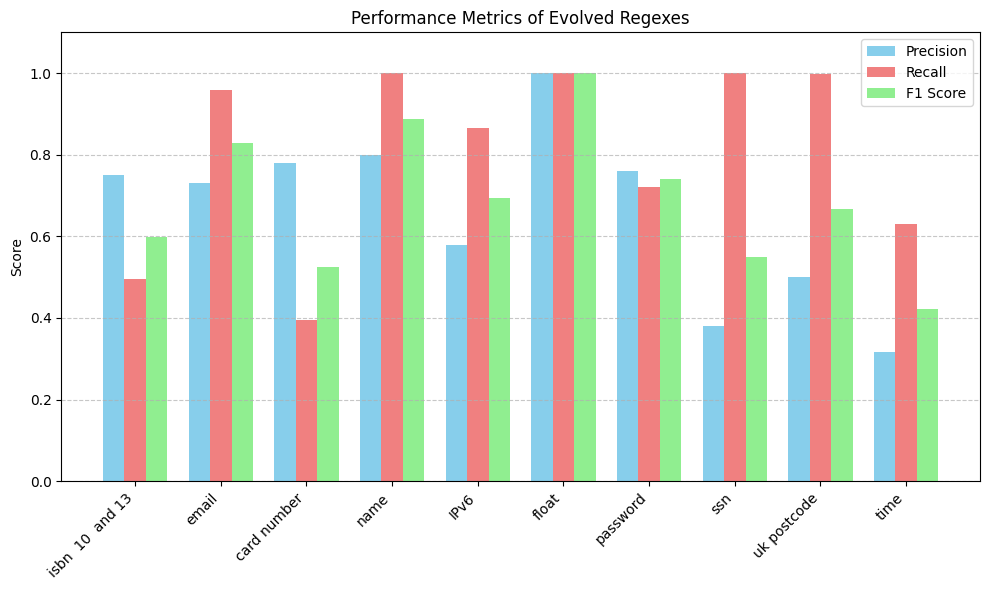

In [13]:
    

EVOLVED_MATCHES_FILE = 'evolved_matches.txt'
ORIGINAL_MATCHES_FILE = 'matches.txt'

def load_json_lines_minimal(filename):
    data = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            line_content = line.strip()
            if line_content:
                data.append(json.loads(line_content))
    return data

def calculate_metrics_minimal(predicted_set, true_set):
    tp = len(predicted_set.intersection(true_set))
    fp = len(predicted_set.difference(true_set))
    fn = len(true_set.difference(predicted_set))

    if not true_set and not predicted_set:
        precision, recall, f1 = 1.0, 1.0, 1.0
    else:
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1

def plot_evolved_performance_minimal():
    evolved_results = load_json_lines_minimal(EVOLVED_MATCHES_FILE)
    original_targets_raw = load_json_lines_minimal(ORIGINAL_MATCHES_FILE)

    original_targets_map = {
        target_def['name']: {'matches_set': set(map(str, target_def['matches']))}
        for target_def in original_targets_raw if 'name' in target_def and 'matches' in target_def
    }

    target_names = []
    f1_scores = []
    precision_scores = []
    recall_scores = []

    for evolved_res in evolved_results:
        original_name = evolved_res['original_target_name']
        if original_name in original_targets_map:
            true_positive_set = original_targets_map[original_name]['matches_set']
            predicted_positive_set = set(map(str, evolved_res.get('matches', [])))
            precision, recall, f1 = calculate_metrics_minimal(predicted_positive_set, true_positive_set)

            target_names.append(original_name)
            f1_scores.append(f1)
            precision_scores.append(precision)
            recall_scores.append(recall)

    num_targets = len(target_names)
    x_indexes = np.arange(num_targets)
    bar_width = 0.25

    fig, ax = plt.subplots(figsize=(max(10, num_targets * 0.8), 6))

    ax.bar(x_indexes - bar_width, precision_scores, bar_width, label='Precision', color='skyblue')
    ax.bar(x_indexes, recall_scores, bar_width, label='Recall', color='lightcoral')
    ax.bar(x_indexes + bar_width, f1_scores, bar_width, label='F1 Score', color='lightgreen')

    ax.set_ylabel('Score')
    ax.set_title('Performance Metrics of Evolved Regexes')
    ax.set_xticks(x_indexes)
    ax.set_xticklabels(target_names, rotation=45, ha="right")
    ax.set_ylim(0, 1.1)
    ax.legend()
    fig.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_evolved_performance_minimal()